In [1]:
import requests
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import linalg
from sklearn.linear_model import Ridge, Lasso
from pytrends.request import TrendReq
import os.path
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# From https://stackoverflow.com/questions/50786266/writing-dictionary-of-dataframes-to-file
import csv
import pandas as pd

def save_dict_df(dictex, keys_filename="keys.txt", data_folder="stock_data"):
    for key, val in dictex.items():
        val.to_csv("./"+data_folder+"/data_{}.csv".format(str(key)))

    with open(keys_filename, "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

def load_dict_df(keys_filename="keys.txt", data_folder="stock_data"):
    """Reading data from keys"""
    with open(keys_filename, "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("./"+data_folder+"/data_{}.csv".format(str(key)), index_col=0)

    return dictex

In [3]:
companies = ['tesla', 'facebook', 'microsoft', 'amazon', 'google', 'uber', 'lyft', 'apple', 'snap']
key_terms = ['report', 'good', 'bad', 'up', 'down', 'stock']
company_symbol = ['TSLA', 'FB', 'MSFT', 'AMZN', 'GOOGL', 'UBER', 'LYFT', 'AAPL', 'SNAP']
stock_columns = ['open', 'high', 'low', 'close', 'volume']

In [4]:
#create kw_list 
kw_list = []
for c_name in companies:
    for k in key_terms:
        kw_list.append(c_name + " " + k)

In [5]:
# Get 3-month ago trend data. May need to run a couple times to make sure it doesn't time out. 
def getTrendDataDF(kw_list, pull_data=False, dates='today 3-m', pytrends_df_filename="pytrends.csv"):
    # Retrieve the cached trend data
    if not pull_data and os.path.isfile(pytrends_df_filename):
        df = pd.read_csv(pytrends_df_filename, index_col="date")
        
    else: # Construct the dataframe by making pytrends calls
        df = pd.DataFrame()
        data = {}
        #print(df.empty)
        pytrends = TrendReq(hl='en-US', tz=360)
        for kw in kw_list:
            pytrends.build_payload([kw], cat=0, timeframe=dates, geo='', gprop='')
            df_temp = pytrends.interest_over_time()
            df_temp = df_temp.drop(['isPartial'], axis=1)
            # print(kw)
            data[kw] = df_temp
        for kw in kw_list:
            if df.empty:
                df = data[kw]
            else:
                df = df.join(data[kw])
        df.to_csv(pytrends_df_filename)
    #reverse df rows
    df = df.iloc[::-1]
    return df

In [6]:
# Get Stock Daily info for past 100 days
def getDailyStockInfoDict(company_symbol, pull_data=False, stock_df_filename="stock_keys.txt"):
    if not pull_data and os.path.isfile(stock_df_filename):
        dict_stocks = load_dict_df(keys_filename=stock_df_filename);
    else :
        ts = 'TIME_SERIES_DAILY'
        api_key = ''
        outputsize = 'compact'
        dict_stocks = {}
        for i, symbol in enumerate(company_symbol):
            link = 'https://www.alphavantage.co/query?function={}&symbol={}&apikey={}&outputsize={}'\
                    .format(ts, symbol, api_key, outputsize)
            r = requests.get(link)
            data = json.loads(r.text)
            # API only give you 5 requests per 5 mins, so break out if response is not what is expected.
            while "Time Series (Daily)" not in data:
                print('...sleeping...')
                time.sleep(70)
                link = 'https://www.alphavantage.co/query?function={}&symbol={}&apikey={}&outputsize={}'\
                    .format(ts, symbol, api_key, outputsize)
                r = requests.get(link)
                data = json.loads(r.text)
            stock_data_per_day = json.dumps(data["Time Series (Daily)"])
            df_temp = pd.read_json(stock_data_per_day).transpose()
            df_temp.reset_index(level=0, inplace=True)
            df_temp.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
            dict_stocks[companies[i]] = df_temp
        save_dict_df(dict_stocks, keys_filename=stock_df_filename)
    return dict_stocks

In [7]:
def getTrends(company_name, df_trends):
    # Filters the trends
    company_keywords =  [x for x in list(df_trends.columns.values) if company_name in x]
    return df_trends[company_keywords].copy()
    

In [8]:
def getJointTimes(df_stock, df_trends): 
    stock_times = df_stock['times']
    trends_times = list(df_trends.index)
    return list(set(stock_times) & set(trends_times)) 

In [9]:
def getOverlapDateData(company_name, dict_stocks, df_trends): 
    new_df_trends = getTrends(company_name, df_trends)
    
    joint_times = getJointTimes(dict_stocks[company_name], new_df_trends)
    new_df_stocks = dict_stocks[company_name].loc[dict_stocks[company_name]['times'].isin(joint_times)]
    new_df_stocks = new_df_stocks.reset_index() 
    
    new_df_trends = new_df_trends.loc[new_df_trends.index.isin(joint_times)]
    new_df_trends = new_df_trends.reset_index()
    new_df_trends.columns = ['_'.join(x.split()) for x in list(new_df_trends.columns) if len(x) > 1]
    df_all_data = new_df_stocks.join(new_df_trends)
    return df_all_data


In [10]:
def trainMultipleRegression(y_col, parameter_cols, training_data): 
    formula = y_col + ' ~ 1'
    for i in parameter_cols: 
        formula = formula + " + " + i

    result = sm.formula.ols(formula=formula, data=training_data).fit()
    return result

In [11]:
def plotMultipleRegressionAndGetMSE(company, result, y_col, cols, all_data, training_data, testing_data):
    y_pred = result.predict()
    plt.plot(range(len(all_data[y_col])) , all_data[y_col])
    plt.plot(range(50), result.predict(training_data[cols]), '-')
    plt.plot(range(50, len(df_all_data[y_col])), result.predict(testing_data[cols]), '-')
    plt.xlabel('Day')
    plt.ylabel('Output $ amount')
    plt.title(company + ' Multiple Regression: ' + str(y_col))
    plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    plt.show()
    
    MSE = mean_squared_error(result.predict(testing_data[cols]), testing_data[y_col]) / (np.mean(testing_data[y_col]) * np.std(testing_data[y_col]))
    return MSE

In [12]:
def getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train):
    df_all_data_test = df_all_data_train[40:]
    df_all_data_train = df_all_data_train[:40]
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    alpha = []
    MSE_train = []
    MSE_test = []
    for i in range(90, 2000, 10):
        clf = Ridge(alpha=i)
        clf.fit(X, y) 
        alpha.append(i)
        MSE_train.append(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col]))
        MSE_test.append(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]))

    bestAlpha = alpha[MSE_test.index(min(MSE_test))]
    
    print("alpha: "+str(bestAlpha))
    print("Training error = "+str(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col])))
    print("Testing error = "+str(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])))
    print()
    return bestAlpha, clf

In [13]:
#ridge regression

def trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, parameter_cols, df_all_data_train, df_all_data_test) : 
    bestAlpha, clf = getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train)
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    
    #plot data with training and test data
    clf = Ridge(alpha=bestAlpha)
    clf.fit(X, y) 
    plt.plot(range(len(df_all_data[y_col])) , df_all_data[y_col])
    plt.plot(range(50), clf.predict(df_all_data_train[cols]), '-')
    plt.plot(range(50, len(df_all_data[y_col])), clf.predict(df_all_data_test[cols]), '-')
    plt.xlabel('Day')
    plt.ylabel('Output $ amount')
    plt.title(company + ' Ridge Regression: ' + str(y_col))
    plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    plt.show()
    
    print(clf.get_params())
    MSE = mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]) / (np.mean(df_all_data_test[y_col]) * np.std(df_all_data_test[y_col]))
    return MSE

In [14]:
def getMovingAvgAndStdDev(col_name, num_days, df_all_data):
    # Moving average and stdev past X days
    col_movingAvg = []
    col_stdev = []
    
    num_days_to_average = 10
    for i in range(len(df_all_data)):
        sum_to_avg = 0
        nums = []
        num_to_avg = min(num_days_to_average, len(df_all_data) - i) - 1
        for j in range(1, num_to_avg):
            sum_to_avg += df_all_data[col][i + j]
            nums.append(df_all_data[col][i + j])
        avg = sum_to_avg / (num_to_avg if num_to_avg > 0 else 1)
        stdev = np.std((nums if nums else [0]))

        col_movingAvg.append(avg)
        col_stdev.append(stdev)
    return col_movingAvg, col_stdev

In [15]:
def getAllParamCols(df_all_data):
    cols = list(df_all_data.columns)
    cols.remove('profit')
    cols.remove('open')
    cols.remove('close')
    cols.remove('high')
    cols.remove('low')
    cols.remove('times')
    cols.remove('date')
    cols.remove('index')
    cols.remove('volume')
    cols.remove('mid')
    return cols

## Get data

In [16]:
# Get trend data
df_trends = getTrendDataDF(kw_list)

In [17]:
# Get stock data
dict_stocks = getDailyStockInfoDict(company_symbol)

## Predicting with all predictors, and only moving averages, std

tesla
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     94.47
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           2.59e-13
Time:                        23:07:04   Log-Likelihood:                -122.60
No. Observations:                  50   AIC:                             313.2
Df Residuals:                      16   BIC:                             378.2
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept             

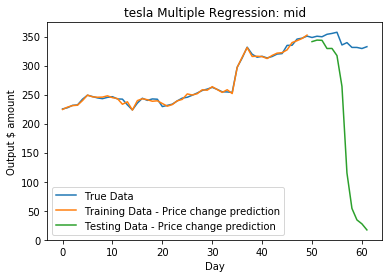

MSE: 9.877592403074722
alpha: 90
Training error = 533.4933788372354
Testing error = 5863.315608977873



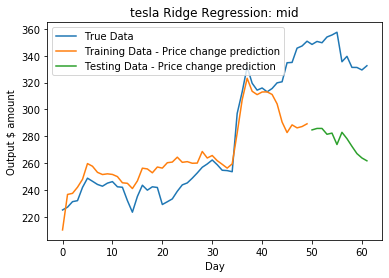

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 1.2650909956617906
No Trend Data
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     14.53
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           4.57e-10
Time:                        23:07:07   Log-Likelihood:                -218.26
No. Observations:                  50   AIC:                             456.5
Df Residuals:                      40   BIC:                             475.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef

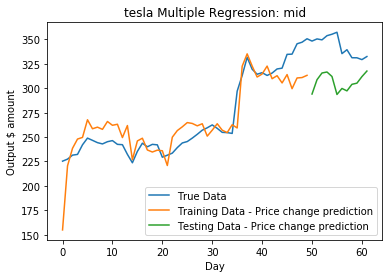

MSE: 0.4328014695154158
alpha: 90
Training error = 600.4630077036176
Testing error = 5960.738323029563



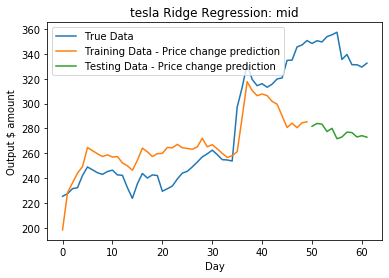

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 1.26070633465114


In [18]:
MSE_dict = {} # {"company":{"multipleRegressionProfit":value, "multipleRegressionCost":value, etc}}
# Join data together, train various models
for company in companies[:1]: 
    print(company)
    MSE_dict[company] = {}
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    
    
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data)
    
    # Include moving average, stdev, and prev. 10 days. 
    num_days_to_average = 10
    col = 'profit'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    col = 'mid'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    col = 'volume'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    # Include movingAvg, stdev, and prev for all the Trends cols
    for col in cols: 
        # Prev info
        col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
        col_prev.append(0) # Append this so we can have 0 padding
        df_all_data[col+'_prev'] = col_prev
        
        col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
        
        df_all_data[col+'_movingAvg'] = col_movingAvg
        df_all_data[col+'_stdev'] = col_stdev

    
    cols = getAllParamCols(df_all_data)
        
    # Reverse index order
    df_all_data = df_all_data.iloc[::-1] 
    
    # Split into training and testing data
    df_all_data_train = df_all_data[:50]
    df_all_data_test = df_all_data[50:]
    
    MSE_dict[company]["MultipleRegression"] = {}
    MSE_dict[company]["RidgeRegression"] = {}
    parameter_type = "allPredictors"
    MSE_dict[company]["MultipleRegression"][parameter_type] = {}
    MSE_dict[company]["RidgeRegression"][parameter_type] = {}
                         
    # Multiple Regression, All Predictors
    y_col='mid'
    close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
    print(close_multiple_regression_res.summary())
    MSE = plotMultipleRegressionAndGetMSE(company, close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
    MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    
    # RIDGE REGRESSION REQUIRES STANDARDIZATION
    # Standardize the input parameters
    df_standardized_data = df_all_data.copy()

    for col in cols: 
        df_standardized_data[col] = df_standardized_data[col] / np.std(df_standardized_data[col].values)
    
    # Split into training and testing data
    df_all_data_train = df_standardized_data[:50]
    df_all_data_test = df_standardized_data[50:]
    
    # Ridge Regression, All Predictors
    MSE = trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, cols, df_all_data_train, df_all_data_test)
    MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    
    
    
    
    #### Predictions using only stock market data #### 
    # Remove any cols in col that has the company name in it. 
    print("No Trend Data")
    cols_noTrends = [col for col in cols if company not in col]
    cols = cols_noTrends
    
    # Split into training and testing data
    df_all_data_train = df_all_data[:50]
    df_all_data_test = df_all_data[50:]
    
    parameter_type = "noTrend"
    MSE_dict[company]["MultipleRegression"][parameter_type] = {}
    MSE_dict[company]["RidgeRegression"][parameter_type] = {}
    
    # Multiple Regression
    close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
    print(close_multiple_regression_res.summary())
    MSE = plotMultipleRegressionAndGetMSE(company, close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
    MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    # Standardize the input parameters
    df_standardized_data = df_all_data.copy()

    for col in cols: 
        df_standardized_data[col] = df_standardized_data[col] / np.std(df_standardized_data[col].values)
    
    # Split into training and testing data
    df_all_data_train = df_standardized_data[:50]
    df_all_data_test = df_standardized_data[50:]
    
    # Ridge Regression
    MSE = trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, cols, df_all_data_train, df_all_data_test)
    MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    

## Predicting with only Google Trends data

tesla
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     19.40
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           7.52e-11
Time:                        23:07:10   Log-Likelihood:                -180.12
No. Observations:                  50   AIC:                             410.2
Df Residuals:                      25   BIC:                             458.0
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept             

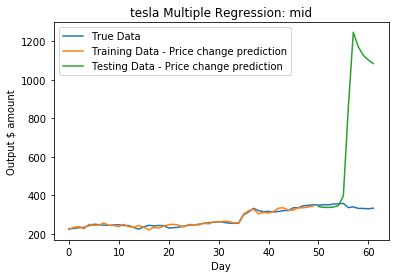

MSE: 85.80311145799472
alpha: 90
Training error = 592.2781275536676
Testing error = 6121.845828952302



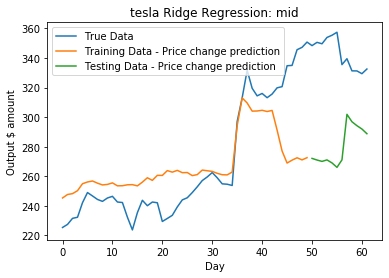

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 1.2538261901231038


In [19]:
# Join data together, train various models
for company in companies[:1]: 
    print(company)
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    
    
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data)
    
    num_days_to_average = 10
    for col in cols: 
        # Prev to today increment amount
        col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
        col_prev.append(0) # Append this so we can have 0 padding
        df_all_data[col+'_prev'] = col_prev
        
        col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
        
        df_all_data[col+'_movingAvg'] = col_movingAvg
        df_all_data[col+'_stdev'] = col_stdev

    
    cols = getAllParamCols(df_all_data)
        
    # Reverse index order
    df_all_data = df_all_data.iloc[::-1] 
    
    # Split into training and testing data
    df_all_data_train = df_all_data[:50]
    df_all_data_test = df_all_data[50:]
    
    
    parameter_type="onlyTrends"
    MSE_dict[company]["MultipleRegression"][parameter_type] = {}
    MSE_dict[company]["RidgeRegression"][parameter_type] = {}
    y_col='mid'
    
    # Profit prediction: 
    close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
    print(close_multiple_regression_res.summary())
    MSE = plotMultipleRegressionAndGetMSE(company, close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
    MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    # Standardize the input parameters
    df_standardized_data = df_all_data.copy()

    for col in cols: 
        df_standardized_data[col] = df_standardized_data[col] / np.std(df_standardized_data[col].values)
    
    # Split into training and testing data
    df_all_data_train = df_standardized_data[:50]
    df_all_data_test = df_standardized_data[50:]
    
    
    # Ridge Regression
    MSE = trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, cols, df_all_data_train, df_all_data_test)
    MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    
    
    
    

In [20]:
def plotMSE(y_col, model):
    for company in companies[:1]:
        plt.plot(["all predictors", "only trends", "no trends"], [MSE_dict[company][model]['allPredictors'][y_col],  MSE_dict[company][model]['onlyTrends'][y_col], MSE_dict[company][model]['noTrend'][y_col]], label=company)

    plt.xlabel("parameter types")
    plt.ylabel("MSE / mean stock price")
    plt.legend()
    plt.title(model + " " + y_col);

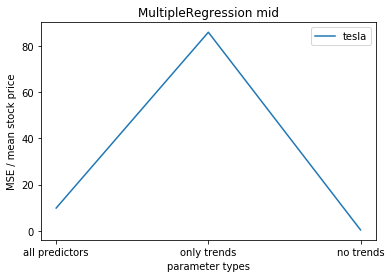

In [21]:
y_col = "mid"
model = "MultipleRegression"
plotMSE(y_col, model)


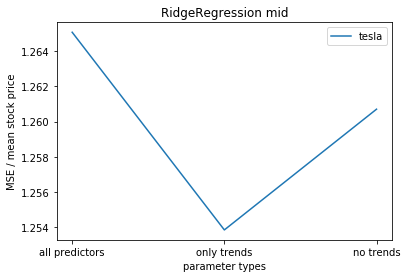

In [22]:
y_col = "mid"
model = "RidgeRegression"
plotMSE(y_col, model)



## Lasso Regression

In [23]:
# Methods for LASSO Regression
def getBestAlphaLASSORegression(y_col, parameter_cols, df_all_data_train):
    split = int(df_all_data_train.shape[0]/2)
    df_all_data_test = df_all_data_train[split:]
    df_all_data_train = df_all_data_train[:split]
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    
    alpha = []
    MSE_train = []
    MSE_test = []
    for i in range(90, 10000, 10):
        clf = Lasso(alpha=i)
        clf.fit(X, y) 
        alpha.append(i)
        MSE_train.append(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col]))
        MSE_test.append(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]))
    
    bestAlpha = alpha[MSE_test.index(min(MSE_test))]
    clf = Lasso(alpha=bestAlpha)
    clf.fit(X, y)
    bestMSE = mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])
    print("alpha: "+str(bestAlpha))
    print("Training error = "+str(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col])))
    print("Testing error = "+str(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])))
    print()
    return bestAlpha, bestMSE

In [24]:
# Define Functions For Plotting LASSO Regression
def plotLASSO(company, alpha, label, predictors, df): 
    # Separate Data
    split = int(df.shape[0]/2)
    df_train = df[:split]
    df_test = df[split:]
    X_train = df_train[predictors]
    Y_train = df_train[label]
    X_test = df_test[predictors]
    Y_test = df_test[label]
    Y_labels = df[label]
    # Initialize Model w/ Optimal Alpha
    clf = Lasso(alpha=alpha)
    clf.fit(X_train, Y_train) 
    df_temp = pd.DataFrame.from_dict(dict([(a,b) for a,b in sorted(zip(clf.coef_, predictors))]),orient='index')
    # Make Predictions using optimal alpha value
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    # Plot test and train predictions against true labels
    
    fig1, ax1 = plt.subplots()
    ax1.plot(range(split), y_pred_train, color='r')
    ax1.plot(range(split, len(Y_labels)),y_pred_test, color='b')
    ax1.plot(range(len(Y_labels)),Y_labels, color='g')
    ax1.set_xlabel('Time in Hours')
    ax1.set_ylabel(label)
    ax1.set_title(label + ' Predictions with LASSO Regression for '+ company)
    plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    plt.show()
    return df_temp

In [25]:
def columnsAll(company, label): 
    cols = getOverlapDateData(company, dict_stocks, df_trends).columns
    cols = list(cols)
    cols.remove('times')
    cols.remove('index')
    cols.remove('date')
    return cols

def columnsTrends(company, label): 
    cols = [x for x in list(getOverlapDateData(company, dict_stocks, df_trends).columns) if company in x]
    return cols

def columnsAverage(company, label): 
    cols = [x for x in list(getOverlapDateData(company, dict_stocks, df_trends).columns) if company not in x]
    cols.remove('times')
    cols.remove('index')
    cols.remove('date')
    cols.remove('open')
    cols.remove('volume')
    cols.remove('high')
    cols.remove('low')
    cols.remove('close')
    return cols

### Plot Predictions w/ All Predictors

In [26]:
keys = ['All Predictors', 'Only Trends','Only Stocks']
MSE = {key: None for key in keys}
MSE_companies = {company: MSE.copy() for company in companies}

microsoft
alpha: 9990
Training error = 16.032620881939657
Testing error = 54.35324760555835



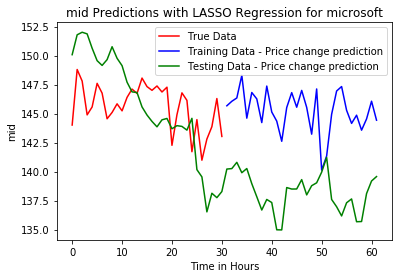

                    0
-3.089690e-07  volume
 0.000000e+00    open


In [27]:
for company in companies[2:3]: 
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    df_all_data['mid'] = (df_all_data['high'] + df_all_data['low'])/2
    print(company)
    # Prepare column list
    cols = columnsAll(company, 'mid') 
    # Find best alpha for LASSO Regression
    alpha, MSE_all = getBestAlphaLASSORegression('mid',cols,df_all_data)
    # Plot Predictions by True Labels
    df_coefficients = plotLASSO(company, alpha, 'mid', cols, df_all_data)
    # Plot MSE for LASSO Regression
    MSE_companies[company]['All Predictors']  = MSE_all
    print(df_coefficients)

alpha: 90
Training error = 19.803294177289295
Testing error = 56.76241751783837



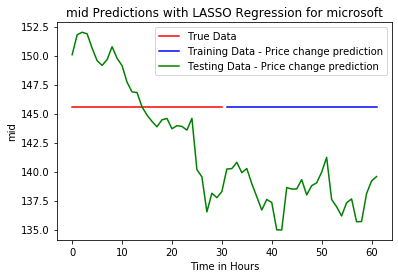

In [28]:
for company in companies[2:3]: 
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    df_all_data['mid'] = (df_all_data['high'] + df_all_data['low'])/2
    # Prepare column list
    cols = columnsTrends(company, 'mid') 
    # Find best alpha for LASSO Regression
    alpha, MSE_trends = getBestAlphaLASSORegression('mid',cols,df_all_data)
    # Plot Predictions by True Labels
    plotLASSO(company, alpha, 'mid', cols, df_all_data)
    # Plot MSE train and test for LASSO Regression
    MSE_companies[company]['Only Trends']  = MSE_trends

alpha: 9990
Training error = 16.032620881939657
Testing error = 54.35324760555835

MSE:  54.35324760555835


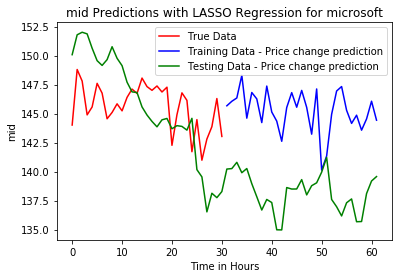

In [29]:
for company in companies[2:3]: 
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    df_all_data['mid'] = (df_all_data['high'] + df_all_data['low'])/2
    # Prepare column list
    cols = stock_columns
    # Find best alpha for LASSO Regression
    alpha, MSE_stock = getBestAlphaLASSORegression('mid',cols, df_all_data)
    print("MSE: ",MSE_stock)
    # Plot Predictions by True Labels
    plotLASSO(company, alpha, 'mid', cols, df_all_data)
    # Plot MSE train and test for LASSO Regression
    MSE_companies[company]['Only Stocks']  = MSE_stock

Text(0.5, 1.0, 'LassoRegression mid')

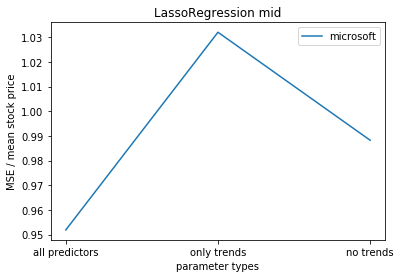

In [30]:
y_col = "mid"
model = "LassoRegression"
plt.plot(["all predictors", "only trends", "no trends"], [52.35324760555835/55, 56.76241751783837/55, 54.35324760555835/55], label=company)
plt.xlabel("parameter types")
plt.ylabel("MSE / mean stock price")
plt.legend()
plt.title(model + " " + y_col)

In [31]:
[52.35324760555835/55, 56.76241751783837/55, 54.35324760555835/55]

[0.95187722919197, 1.0320439548697886, 0.9882408655556064]

## Tensorflow + Keras time

In [32]:
# scale data to be between 0-1 
def predictCompany(df_temp, train_size, cols):
    # scale data to be between 0-1 including average
    sc = MinMaxScaler(feature_range = (0, 1))
    data_set_scaled = sc.fit_transform(df_temp[cols+['mid']])
    
    #split training data 
    train = data_set_scaled[:train_size, :]
    test = data_set_scaled[train_size:, :]
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    #create model
    model = Sequential()
    model.add(LSTM(train_size, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    #train model
    history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    return history, model, train_X, train_y, test_X, test_y

In [33]:
def plotPrediction(company, train_size, model, train_X, train_y, test_X, test_y):
    plt.plot(range(len(train_y)+len(test_y)) , list(np.array(train_y))+list(np.array(test_y)), range(len(train_y)), model.predict(train_X), '-', range(len(train_y), len(train_y)+len(test_y)), model.predict(test_X), '-')
    plt.xlabel('Day')
    plt.ylabel('Profit from previous day')
    plt.title(company + ' - predicting stock market with Keras')
    plt.legend(["True Data","Training Data", "Testing Data"])
    plt.show()

In [34]:
def plotHistory(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

tesla


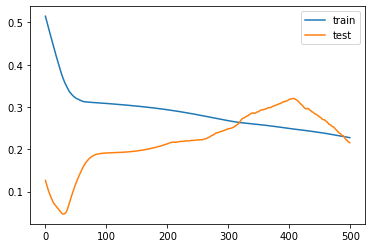

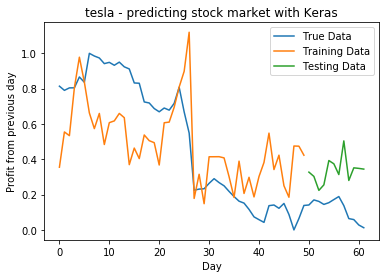

facebook


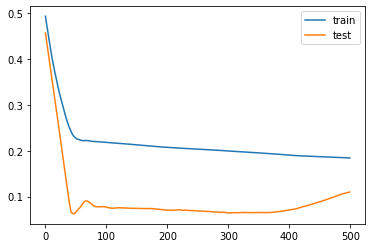

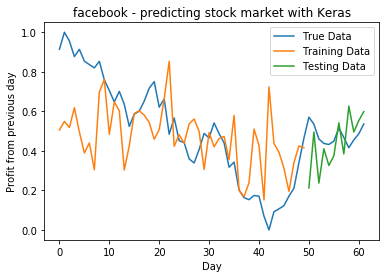

microsoft


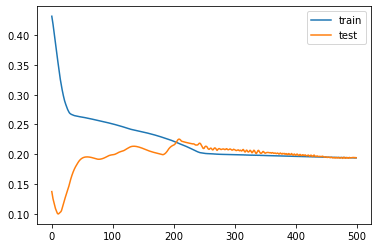

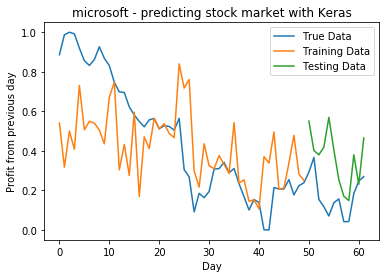

amazon


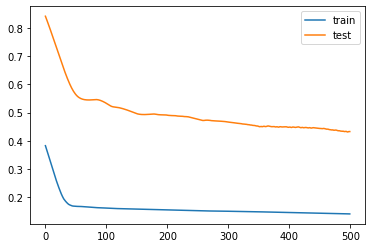

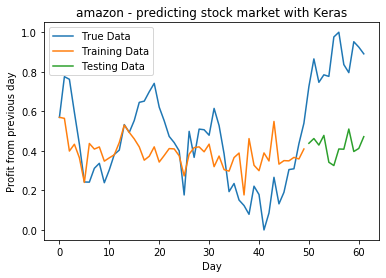

google


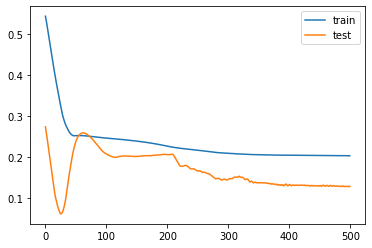

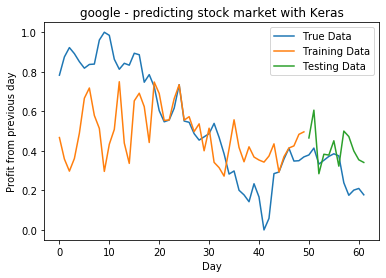

uber


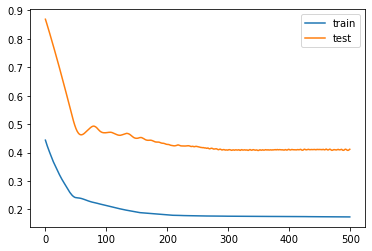

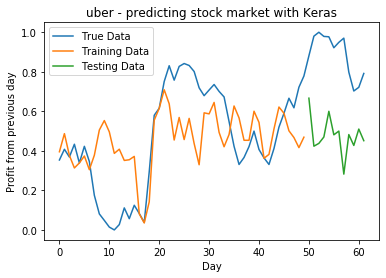

lyft


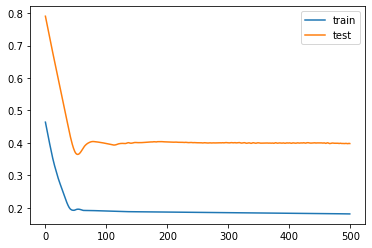

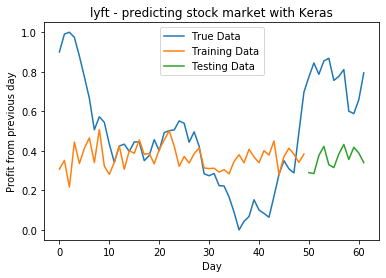

apple


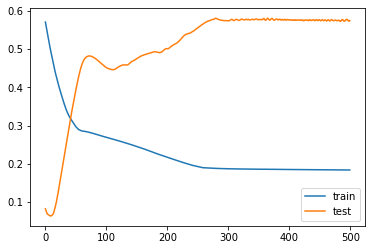

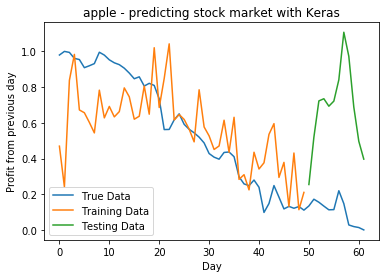

snap


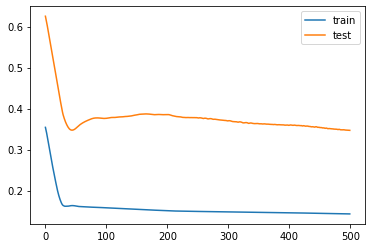

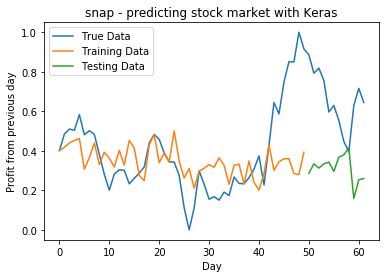

In [35]:
#Trends only!
MSE_train_trends_only = []
MSE_test_trends_only = []
for company in companies: 
    print(company)
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data)
    
    # Plotting only Google Trends data 
    history, model, train_X, train_y, test_X, test_y = predictCompany(df_all_data, 50, cols)
    plotHistory(history)
    plotPrediction(company, 50, model, train_X, train_y, test_X, test_y)
    MSE_train_trends_only.append((company, mean_squared_error(model.predict(train_X), train_y)))
    MSE_test_trends_only.append((company, mean_squared_error(model.predict(test_X), test_y)))


tesla


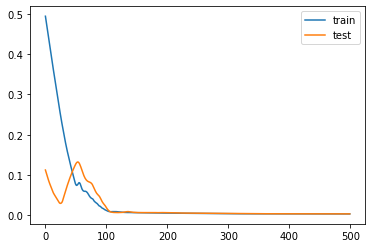

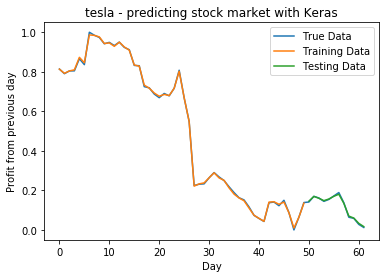

facebook


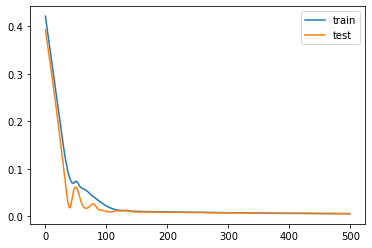

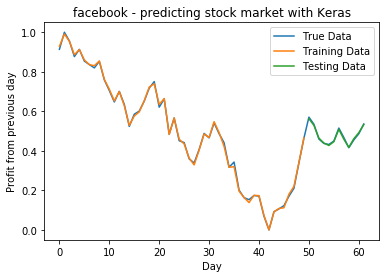

microsoft


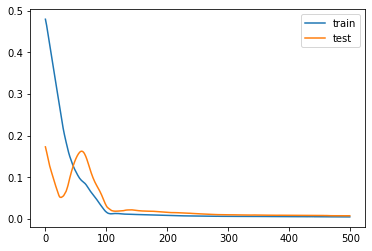

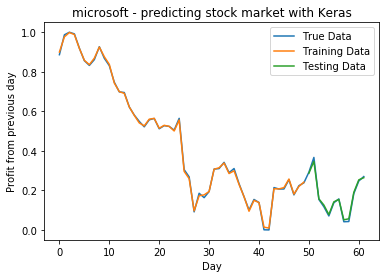

amazon


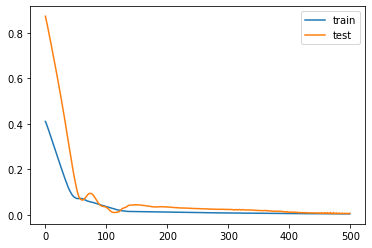

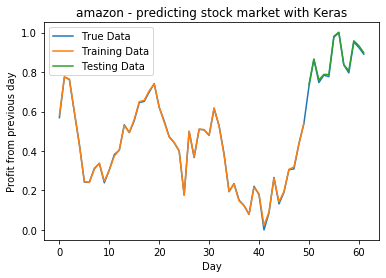

google


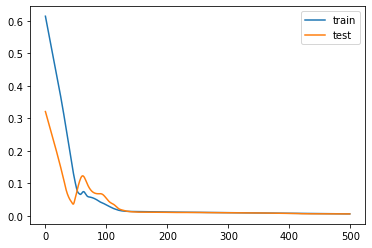

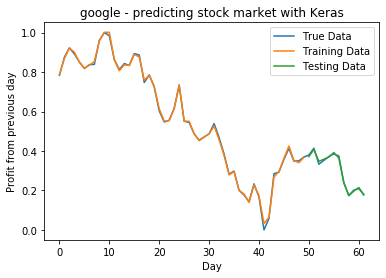

uber


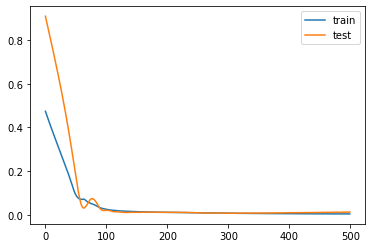

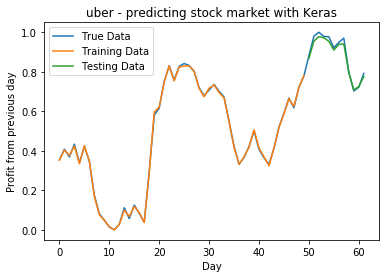

lyft


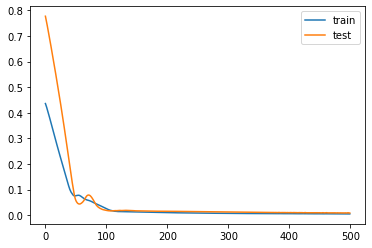

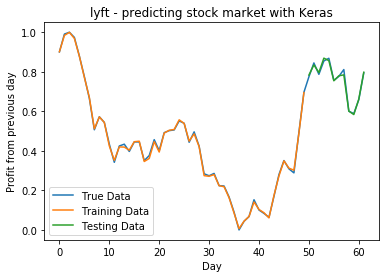

apple


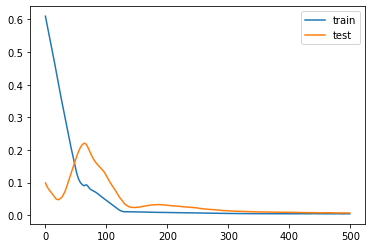

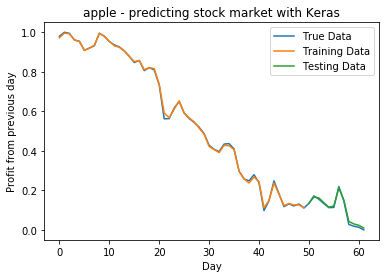

snap


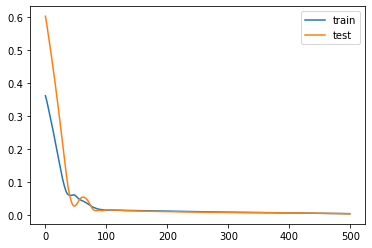

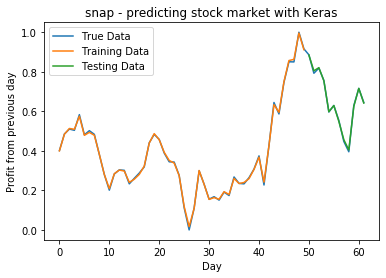

In [36]:
#Stock only!
MSE_train_stock_only = []
MSE_test_stock_only = []
for company in companies: 
    print(company)
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = stock_columns
    
    # Plotting only Google Trends data 
    history, model, train_X, train_y, test_X, test_y = predictCompany(df_all_data, 50, cols)
    plotHistory(history)
    plotPrediction(company, 50, model, train_X, train_y, test_X, test_y)
    MSE_train_stock_only.append((company, mean_squared_error(model.predict(train_X), train_y)))
    MSE_test_stock_only.append((company, mean_squared_error(model.predict(test_X), test_y)))


tesla


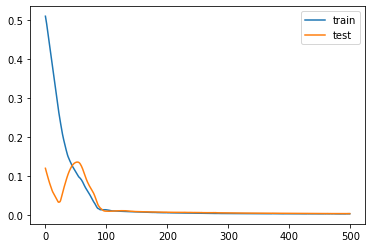

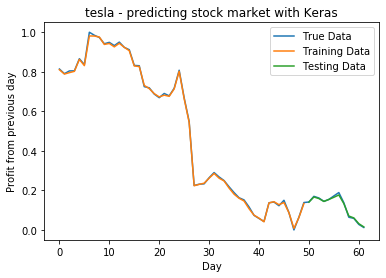

facebook


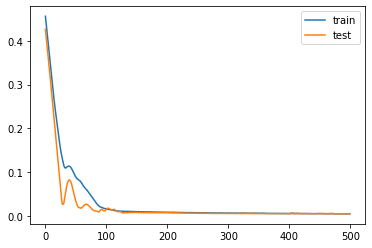

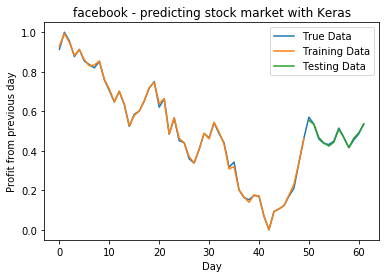

microsoft


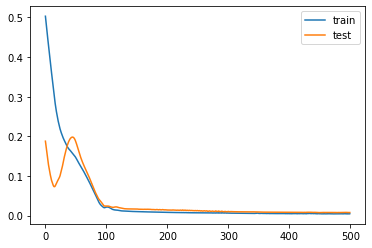

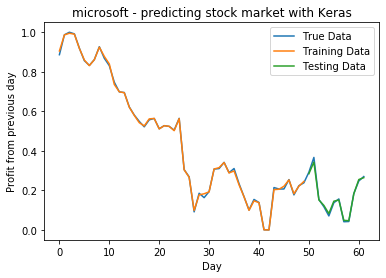

amazon


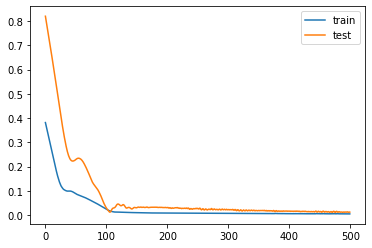

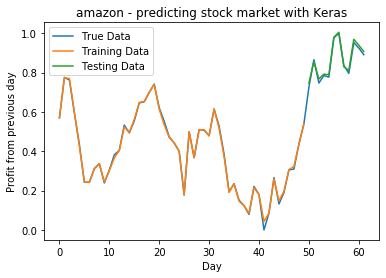

google


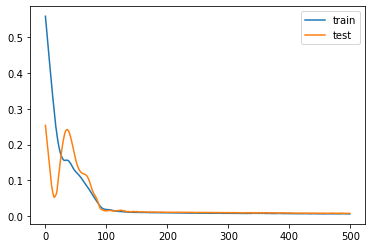

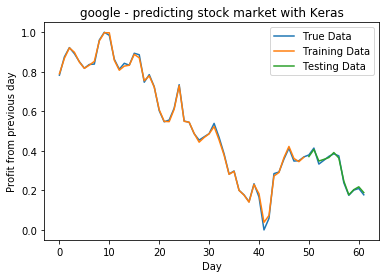

uber


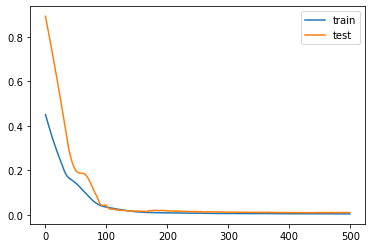

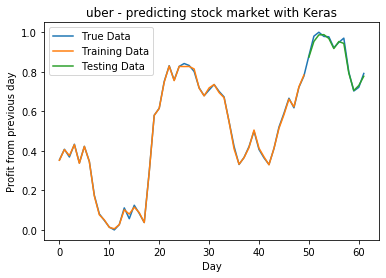

lyft


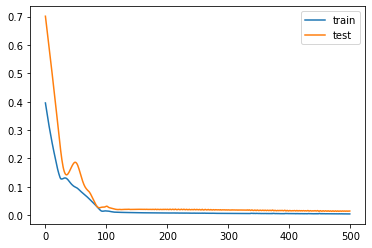

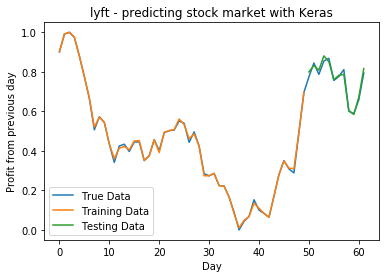

apple


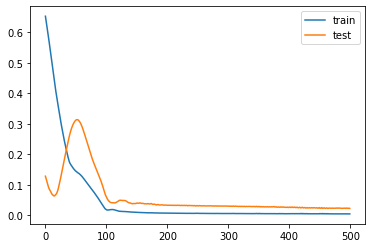

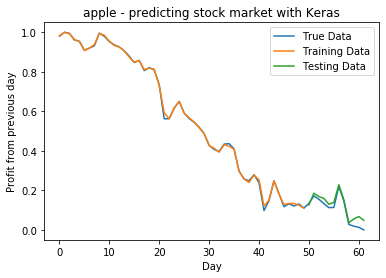

snap


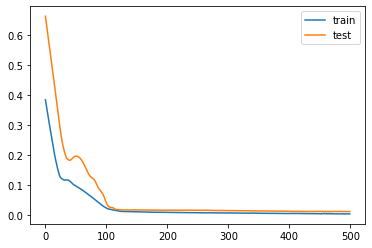

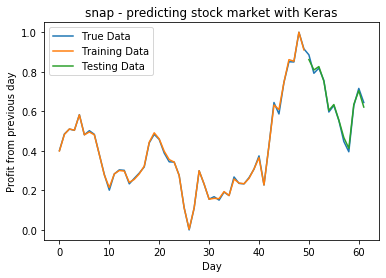

In [37]:
#both trends and stock!
MSE_train_both = []
MSE_test_both = []
for company in companies: 
    print(company)
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data) + stock_columns
    
    # Plotting only Google Trends data 
    history, model, train_X, train_y, test_X, test_y = predictCompany(df_all_data, 50, cols)
    plotHistory(history)
    plotPrediction(company, 50, model, train_X, train_y, test_X, test_y)
    MSE_train_both.append((company, mean_squared_error(model.predict(train_X), train_y)))
    MSE_test_both.append((company, mean_squared_error(model.predict(test_X), test_y)))


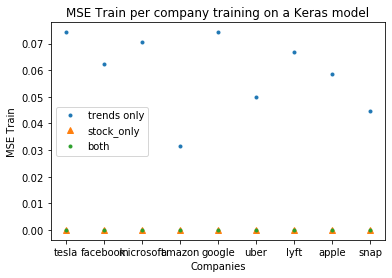

In [38]:
#plot MSE_train data points as scatter plots
X = [x[0] for x in MSE_train_both]
trends_only = [x[1] for x in MSE_train_trends_only]
stock_only = [x[1] for x in MSE_train_stock_only]
both = [x[1] for x in MSE_train_both]
fig, ax = plt.subplots()
plt.plot(X,trends_only, '.', X, stock_only, '^', X, both, '.')
plt.xlabel('Companies')
plt.ylabel('MSE Train')
plt.title('MSE Train per company training on a Keras model')
ax.legend(['trends only', 'stock_only', 'both'])
plt.show()

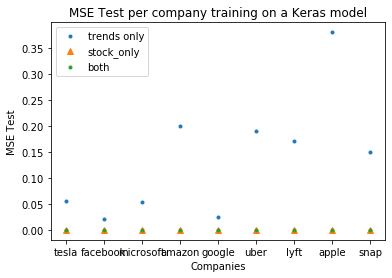

In [39]:
#plot MSE_test data points as scatter plots
X = [x[0] for x in MSE_test_both]
trends_only = [x[1] for x in MSE_test_trends_only]
stock_only = [x[1] for x in MSE_test_stock_only]
both = [x[1] for x in MSE_test_both]
fig, ax = plt.subplots()
plt.plot(X,trends_only, '.', X, stock_only, '^', X, both, '.')
plt.xlabel('Companies')
plt.ylabel('MSE Test')
plt.title('MSE Test per company training on a Keras model')
ax.legend(['trends only', 'stock_only', 'both'])
plt.show()

   tesla [2.5108109169131418e-05, 0.055140530392454416, 1.740860363333187e-05]
   facebook [4.637408267598511e-05, 0.02159246653139292, 2.895118590266234e-05]
   microsoft [8.896809248690462e-05, 0.05374467387475489, 8.13430294994005e-05]
   amazon [0.000180756246625695, 0.20093868625884934, 6.550726872161715e-05]
   google [6.908808495826464e-05, 0.0248705564225577, 4.6042091260807475e-05]
>> uber [0.0001789081342071108, 0.1897940258948033, 0.0002762021881256421]
   lyft [0.0002961403200123759, 0.17110500848370858, 0.00011570700905065702]
   apple [0.0007395188947994197, 0.3804464102771905, 6.469869404301401e-05]
   snap [0.0002004590719972381, 0.15003011338059782, 3.20514431326252e-05]
numBetter: 1 out of: 9
percent better: 0.1111111111111111


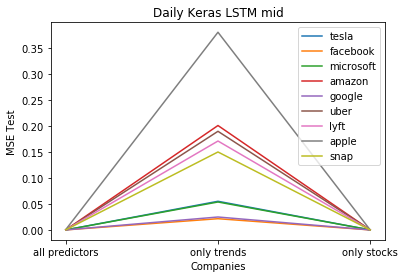

In [41]:
#plot MSE_test data points as scatter plots
X = [x[0] for x in MSE_test_both]
trends_only = [x[1] for x in MSE_test_trends_only]
stock_only = [x[1] for x in MSE_test_stock_only]
both = [x[1] for x in MSE_test_both]
fig, ax = plt.subplots()
numBetter = 0
totalCompanies = 0
for i,c in enumerate(companies):
    plt.plot(["all predictors", "only trends", "only stocks"], [both[i], trends_only[i], stock_only[i]], label=c)
    if(both[i] < stock_only[i]) or (trends_only[i] < stock_only[i]):
        numBetter += 1
        print(">>", c,[both[i], trends_only[i], stock_only[i]])
    else : print("  ",c,[both[i], trends_only[i], stock_only[i]])
    totalCompanies += 1
print("numBetter:", numBetter, "out of:",  totalCompanies)
print("percent better:", numBetter / totalCompanies)
plt.xlabel('Companies')
plt.ylabel('MSE Test')
plt.legend()
plt.title("Daily " + 'Keras LSTM' + " mid")
plt.show()